In [ ]:
!pip install awswrangler mlflow==2.13.2 sagemaker-mlflow==0.1.0 wordcloud

In [2]:
# Define libraries for ML experimentation
import pandas as pd
import awswrangler as wr
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo 
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import boto3
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
import os
import mlflow
import mlflow.sklearn

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### SageMaker variables initialization

In [5]:
# Initialize SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()  # Ensure your role has necessary permissions
bucket = "bucket_name"  # Default S3 bucket
prefix = "prefix"


tracking_server_arn = 'arn:aws:sagemaker:us-east-1:**************:mlflow-tracking-server/mlflow-experiment-1'

### Data Loading and Preparation

In [9]:
df_movie_dataset =  wr.s3.read_csv(f"s3://{bucket}/imdb_dataset.csv")

In [10]:
# uni-code library
import unicodedata
# regular expression library
import re

def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    # removes line breaks from string
    remove_line_breaks = re.sub(r'<br\s*/?>', '', string)
    # removes all non-whitespace and non-words characters
    string = re.sub(r'[^\w\s]', '', remove_line_breaks).lower()
    
    return string

In [11]:
# Clean the reviews column
df_movie_dataset = df_movie_dataset.assign(cleaned_review='')
df_movie_dataset['cleaned_review'] = df_movie_dataset['review'].apply(basic_clean)

In [12]:
# Split into train and test data before encoding categorical
X_train, X_test, y_train, y_test = train_test_split(df_movie_dataset['cleaned_review'], df_movie_dataset['sentiment'], test_size=0.33, random_state=42)

In [13]:
# encode the categorical values in the sentiment column
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [14]:
# Save training and testing data to CSV
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
test_data = pd.DataFrame({'text': X_test, 'label': y_test})

### Data Exploration

In [15]:
training_sentiment_counts = pd.Series(y_train).value_counts()
testing_sentiment_counts = pd.Series(y_test).value_counts()

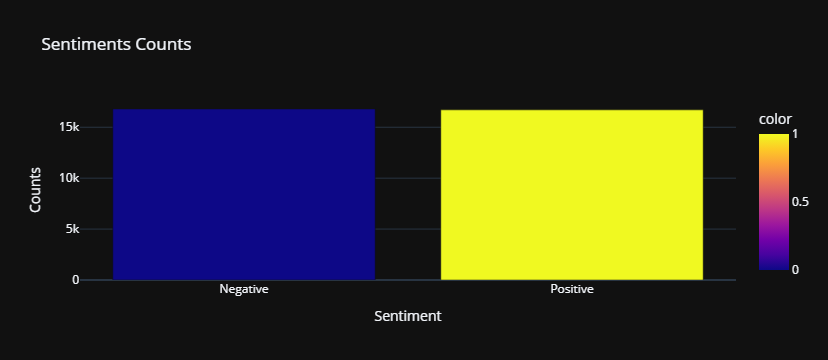

'Training Sentiments Counts.html'

In [16]:
fig =px.bar(x= {0:'Negative',1:'Positive'},
            y= training_sentiment_counts.values,
            color=training_sentiment_counts.index,
            color_discrete_sequence =  px.colors.qualitative.Dark24,
            title='<b>Training Sentiments Counts')
 
fig.update_layout(title='Sentiments Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')
 
# Show the bar chart
fig.show()
pyo.plot(fig, filename = 'Training Sentiments Counts.html', auto_open = True)

In [17]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, 
                          height=400,
                          stopwords=set(STOPWORDS), 
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()


#### Generate a visual graph of the frequently occuring words in a text corpus using wordcloud

##### Training Dataset wordcloud

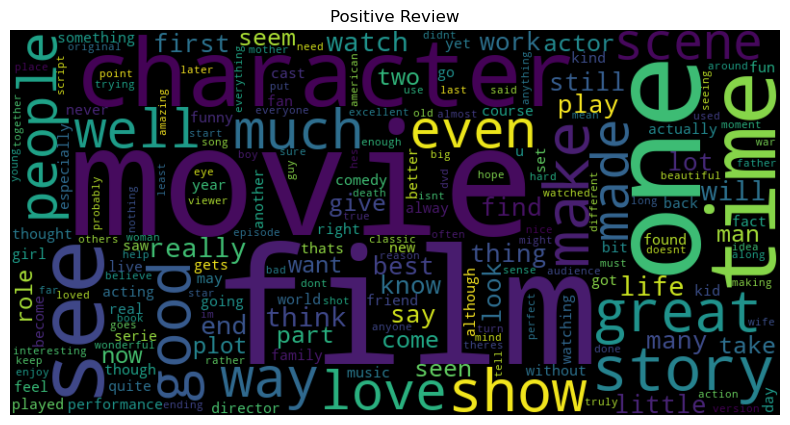

In [18]:
train_df = df_movie_dataset.loc[X_train.index]
positive = train_df[train_df['sentiment']=='positive']['cleaned_review'].tolist()
generate_wordcloud(positive,'Positive Review')

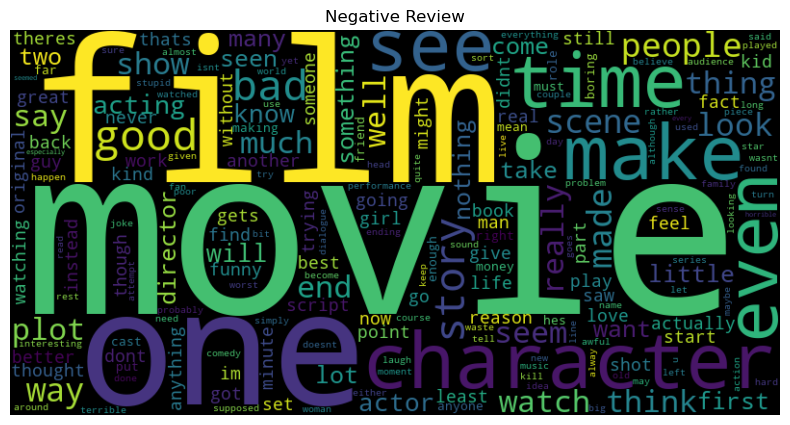

In [19]:
negative = train_df[train_df['sentiment']=='negative']['cleaned_review'].tolist()
generate_wordcloud(negative,'Negative Review')

Test Dataset wordcloud

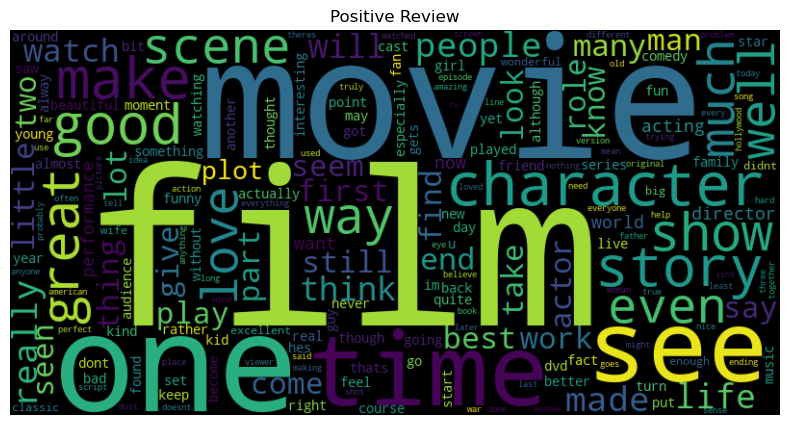

In [25]:
test_df = df_movie_dataset.loc[X_test.index]
positive = test_df[test_df['sentiment']=='positive']['cleaned_review'].tolist()
generate_wordcloud(positive,'Positive Review')

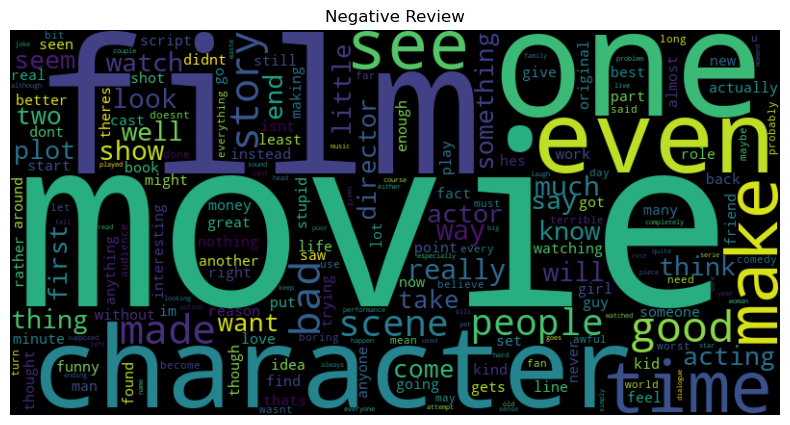

In [26]:
negative = test_df[test_df['sentiment']=='negative']['cleaned_review'].tolist()
generate_wordcloud(negative,'Negative Review')

In [ ]:
# Save CSV files in local directory
os.makedirs('data', exist_ok=True)
train_data.to_csv('data/train.csv', index=False) 
test_data.to_csv('data/test.csv', index=False)

In [ ]:
# Upload data to S3
train_s3_path = sagemaker_session.upload_data(path='data/train.csv', bucket=bucket, key_prefix=prefix)
test_s3_path = sagemaker_session.upload_data(path='data/test.csv', bucket=bucket, key_prefix=prefix)
print(f"Training data uploaded to: {train_s3_path}")
print(f"Testing data uploaded to: {test_s3_path}")

### Model Engineering

In [4]:
# Define S3 locations
train_data_s3 = "s3://bucket_name/prefix/train.csv"
test_data_s3 = "s3://bucke_name/prefix/test.csv"
output_path = f"s3://{bucket}/output"


In [5]:
script_path = "training_code/svm_sentiment_analysis.py"
script_content = """
import argparse
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import mlflow
def train(args):

    input_train_data_path = args.input_train_data
    input_test_data_path = args.input_test_data
    output_data_path = args.output_data
    method = args.method
    max_features = args.max_features
    
    # Load training data
    train_data = pd.read_csv(os.path.join(input_train_data_path, "train.csv"))
    validation_data = pd.read_csv(os.path.join(input_test_data_path, "test.csv"))
    X_train = train_data["text"]
    y_train = train_data["label"]

    print("data has been read")
    X_validation = validation_data["text"]
    y_validation = validation_data["label"]

    # set the tracking server uri using the arn of the tracking server you created
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_ARN'])

    # Enable autologging in MLFlow
    mlflow.autolog()

    
    # Feature extraction
    if method == "tfidf":
        vectorizer = TfidfVectorizer(max_features=max_features)
    elif method == "bow":
        vectorizer = CountVectorizer(max_features=max_features)
    else:
        raise ValueError("Invalid feature extraction method. Choose 'tfidf' or 'bow'.")
    
    X_train_vec = vectorizer.fit_transform(X_train)
    X_validation_vec = vectorizer.transform(X_validation)

    print("vectorizing completed")
    # Train SVM
    svm = SVC(C=args.C, kernel=args.kernel, gamma=args.gamma)
    svm.fit(X_train_vec, y_train)
    print("training completed")
    # Evaluate and log accuracy
    y_pred = svm.predict(X_validation_vec)
    print("prediction done")
    accuracy = accuracy_score(y_validation, y_pred)
    f1 = f1_score(y_validation, y_pred, average="macro")
    precision = precision_score(y_validation, y_pred, average="macro")
    recall = recall_score(y_validation, y_pred, average="macro")
    print(f"validation:accuracy={accuracy}")
    print(f"validation:f1={f1}")
    print(f"validation:precision={precision}")
    print(f"validation:recall={recall}")
    
    # Save model and vectorizer 
    os.makedirs(output_data_path, exist_ok=True)
    import joblib
    joblib.dump(svm, os.path.join(output_data_path, "svm_model.pkl"))
    joblib.dump(vectorizer, os.path.join(output_data_path, "vectorizer.pkl"))
    print("Model and vectorizer saved.")

    # Register the model with MLflow
    run_id = mlflow.last_active_run().info.run_id
    artifact_path = "model"
    model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=artifact_path)
    model_details = mlflow.register_model(model_uri=model_uri, name="svm-experiment-model")
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--input-train-data", type=str, default="/opt/ml/input/data/train")
    parser.add_argument("--input-test-data", type=str, default="/opt/ml/input/data/test") 
    parser.add_argument("--output-data", type=str, default="/opt/ml/model") 
    parser.add_argument("--method", type=str, default="tfidf")
    parser.add_argument("--max-features", type=int, default=5000)
    parser.add_argument("--C", type=float, default=1.5)
    parser.add_argument("--kernel", type=str, default="rbf")
    parser.add_argument("--gamma", type=float, default=0.4)
    args = parser.parse_args()
    train(args)
"""
with open(script_path, "w") as f:
    f.write(script_content)

In [6]:
%%writefile training_code/requirements.txt
mlflow==2.13.2
sagemaker-mlflow==0.1.0
cloudpickle==2.2.1

Overwriting training_code/requirements.txt


In [7]:
# Define the SKLearn estimator

 # path to your SVM training script
sklearn_estimator = SKLearn(
    entry_point='svm_sentiment_analysis.py',
    source_dir='source_code_of_script_and_requirements.txt',
    framework_version="1.2-1",
    instance_type="ml.c6i.xlarge",
    instance_count=1,
    role=role,
    output_path=output_path,
    sagemaker_session=sagemaker_session,
    keep_alive_period_in_seconds=3600,
    hyperparameters={"method": "tfidf", "max-features": 10000},
    environment={
        'MLFLOW_TRACKING_ARN': tracking_server_arn
    }
)



In [ ]:
# Fit the sklearn model to the training data and perform evaluation with the testing data
sklearn_estimator.fit({"train" : train_data_s3, "test" : test_data_s3})

In [ ]:
vectorizer = sklearn_estimator.model_data + "/vectorizer.pkl"
print(vectorizer)

In [ ]:
# Deploy model as an endpoint (optional)
predictor = sklearn_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")

In [ ]:
import tarfile
import os

def extract_targz(tar_gz_file, extract_to='.'):
    try:
        # Open the tar.gz file
        with tarfile.open(tar_gz_file, 'r:gz') as tar:
            # Extract all contents
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tar_gz_file} to {extract_to}")
    except tarfile.TarError as e:
        print(f"Error extracting {tar_gz_file}: {str(e)}")
    except FileNotFoundError:
        print(f"File not found: {tar_gz_file}")
    except PermissionError:
        print(f"Permission denied: Unable to extract to {extract_to}")

# Define model file name and directory to extract to
tar_gz_file = 'model.tar.gz'
extract_to = 'model'

# Create the destination folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Call the function to extract
extract_targz(tar_gz_file, extract_to)

In [20]:
import joblib
def read_pickle_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            data = joblib.load(file)
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    # except pickle.UnpicklingError:
    #     print(f"Error unpickling the file: {file_path}")
    except Exception as e:
        print(f"An error occurred while reading the file: {str(e)}")
    return None

# Define model pickle file name
svm_file_path = 'model/svm_model.pkl'
svm = read_pickle_file(svm_file_path)

# Define vectorizer pickle file name
vectorizer_file_path = 'model/vectorizer.pkl'
vectorizer = read_pickle_file(vectorizer_file_path)

if svm is not None and vectorizer is not None:
    print("Data loaded successfully:")

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 0.23.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



Data loaded successfully:


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning:

Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



### Model Evaluation

In [24]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)

In [23]:
# Use the same vectorizer for feature extraction
# vectorizer = sklearn_estimator.model_data + "/vectorizer.pkl"
vectorized_test_data = vectorizer.transform(X_test)
predictions = svm.predict(vectorized_test_data)
accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7483


### Model Deployment

In [ ]:
# Deploy model as an endpoint (optional)
predictor = sklearn_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")

### Hyperparameter Tuning

In [7]:
# Define hyperparameter ranges
hyperparameter_ranges = {
    "C": ContinuousParameter(0.1, 10.0),
    "kernel": CategoricalParameter(["linear", "rbf", "poly"]),
    "gamma" : ContinuousParameter(0.0001, 1.0),
    "method": CategoricalParameter(["tfidf", "bow"])
}



In [8]:
# Objective metric for tuning
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"
metric_definitions = [
    {
        "Name":"validation:accuracy", # Metric name in the tuner
        "Regex": "validation:accuracy=([0-9\\.]+)"
    }
]


In [9]:
# Define the tuner
tuner = HyperparameterTuner(
    estimator=sklearn_estimator,
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=3,
    metric_definitions=metric_definitions
)

In [3]:
# launch the tuning job
tuner.fit(
    {"train": train_data_s3, "validation": test_data_s3},
    wait=True,
    logs=True
)
print("Hyperparameter tuning job launched!")